# SAS 해커톤에 쓰일 dummy data maker

### 기본세팅

In [57]:
import pandas as pd
import numpy as np
np.set_printoptions(threshold=10)
from faker import Faker
fake_ko = Faker('ko_KR')

import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from collections import defaultdict

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# 폰트 설정
from matplotlib import font_manager, rc
font_name = "Malgun Gothic"  # 나눔고딕 폰트 이름 (이미 설치되어 있다고 가정)

rc('font', family=font_name)
# 그래프에 마이너스 폰트 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False



In [58]:
# 데이터는 총 num_samples 개
## 수급자
num_samples = 100007
## 부당비율 3% 가정
fraud_ratio = int(0.03 * num_samples)
## 종사자

## 기관


## 수급자 정보

### L번호 생성

In [59]:
# l번호 생성
def generate_longtermcare_id():
    prefix = 'L'
    year = str(random.randint(8, 24)).zfill(2)  # 2자리로 만들기 위해 zfill 사용
    middle = '00'
    random_number = str(random.randint(0, 99999)).zfill(5)  # 6자리로 만들기 위해 zfill 사용
    
    # 최종 인정관리번호 생성
    longtermcare_id = f"{prefix}{year}{middle}{random_number}"    
    return longtermcare_id

In [60]:
# l번호 생성 후 저장
print(f'sample: {generate_longtermcare_id()}')
longtermcare_id = np.array([generate_longtermcare_id() for _ in range(num_samples)])
longtermcare_id.shape, len(np.unique(longtermcare_id))

sample: L110099675


((100007,), 97193)

In [61]:
# l번호의 중복 제거
# 중복된 ID 찾기
unique_ids, counts = np.unique(longtermcare_id, return_counts=True)
duplicates = unique_ids[counts > 1]

# ID별로 인덱스 저장
id_to_indices = defaultdict(list)
for idx, id_value in enumerate(longtermcare_id):
    id_to_indices[id_value].append(idx)

# 중복된 ID 처리
for dup_id in duplicates:
    indices = id_to_indices[dup_id]
    # 첫 번째 ID는 그대로 두고, 나머지 중복된 ID 수정
    for count, idx in enumerate(indices[1:], start=1):
        new_middle = str(count).zfill(2)  # '01', '02', '03' 등으로 변경
        new_id = dup_id[:3] + new_middle + dup_id[5:]
        # 새로운 ID가 기존 ID와 중복되지 않도록 확인
        while new_id in longtermcare_id:
            count += 1
            new_middle = str(count).zfill(2)
            new_id = dup_id[:3] + new_middle + dup_id[5:]
        # 수정된 ID를 배열에 업데이트
        longtermcare_id[idx] = new_id
        # ID 인덱스 매핑 업데이트
        id_to_indices[new_id] = [idx]

# 최종 고유 ID의 수 출력
print(f"최종 고유 ID 수: {len(np.unique(longtermcare_id))}")

최종 고유 ID 수: 100007


### 이름 생성

In [62]:
# 초성, 중성, 종성 인덱스 리스트
#초성 = ㄱ  ㄴ ㄷ ㄹ ㅁ ㅂ  ㅅ  ㅇ ㅈ  ㅊ  ㅌ ㅍ ㅎ
#중성 = ㅏ1 ㅐ3 ㅒ4 ㅓ6  ㅕ8  ㅗ9 ㅘ12   ㅛ13 ㅜ17    ㅠ18 ㅡ 19ㅢ20 ㅣ
#종성 = ㄱ  ㄴ  ㄷ ㄹ   ㅁ ㅂ  ㅅ  ㅇ ㅈ 
choseong_list = [0, 2, 3, 5, 6, 7, 9, 11, 12, 14, 16, 17, 18]
#jungseong_list = [0, 1, 3, 4, 6, 8, 9, 12, 13, 17, 18, 19, 20]  
jungseong_list = [0, 4, 8, 13, 20]   # ㅏ ㅓ ㅗ ㅜ ㅣ  이중모음 제외 
#jongseong_list = [0, 1, 4, 7, 8, 16, 17, 19, 21, 22]  # 받침 없는 경우 0 포함  ㄱ ㄴ  ㄹ ㅁ ㅇ 0 4 8 16 21
jongseong_list = [0, 4, 8, 16, 21]  # 받침 없는 경우 0 포함  ㄱ ㄴ  ㄹ ㅁ ㅇ 0 4 8 16 21
jongseong_weights = [5 if jongseong == 0 else 1 for jongseong in jongseong_list]

# 유니코드 한글 범위에서 종성을 분리하여 쌍자음 받침을 제외하는 함수
def generate_random_korean_char():

    choseong = random.choice(choseong_list)
    jungseong = random.choice(jungseong_list)
    jongseong = random.choices(jongseong_list, weights=jongseong_weights, k=1)[0]
    
    # 유니코드 한글 음절 계산
    syllable_code = 0xAC00 + (choseong * 21 * 28) + (jungseong * 28) + jongseong
    syllable_char = chr(syllable_code)
    return syllable_char
        
#랜덤이름 만들기
def generate_random_korean_name():
    # 성만들기
    last_name = fake_ko.last_name()

    # 유니코드 한글 범위 (가~힣)
    first_char = generate_random_korean_char()  # 초성부터 종성까지 한 글자
    second_char = generate_random_korean_char()  # 두 번째 글자
    # 성과 이름 결합
    full_name = last_name + first_char + second_char

    return full_name

In [63]:
#jungseong_list
for i in jongseong_list:
    syllable_code = 0xAC00 + (0 * 21 * 28) + (0 * 28) + i
    syllable_char = chr(syllable_code)
    print(i, syllable_char)

    
    

0 가
4 간
8 갈
16 감
21 강


In [64]:
# 이름 생성
print(f'sample: {generate_random_korean_name()}')
name = np.array([generate_random_korean_name() for _ in range(num_samples)])
name.shape, len(np.unique(name))

sample: 배히퍼


((100007,), 87230)

### 등급 생성

In [65]:
# 각 등급별로 랜덤 샘플링
grade_list = np.arange(1, 6) ## 1~5
grade_ratio = [4.2, 7.8, 24.0, 40.9, 10.3]
grade_ratio = np.array(grade_ratio) / 100 * num_samples
grade_ratio = grade_ratio / grade_ratio.sum()
grade = np.random.choice(grade_list, size=num_samples, p=grade_ratio)
'result:', grade, grade.shape, np.unique(grade)

('result:', array([3, 3, 3, ..., 3, 3, 4]), (100007,), array([1, 2, 3, 4, 5]))

### 생년월일 생성

In [66]:
# 생년월일
def generate_birthdates(min_age, max_age, std_dev, reference_date=datetime(2024, 8, 31)):
    """
    지정된 나이 범위와 표준편차를 기반으로 정규분포된 나이를 생성하고,
    해당 나이에 맞는 생년월일 리스트를 반환하는 함수입니다.

    인자:
    - min_age (int): 최소 나이
    - max_age (int): 최대 나이
    - std_dev (float): 나이의 표준편차
    - reference_date (datetime): 기준 날짜 (기본값: 2024년 8월 31일)

    반환값:
    - birthdates (list): 생년월일 문자열의 리스트 (형식: 'YYYY-MM-DD')
    """
    # 1. 생년월일 범위 설정
    earliest_birthdate = reference_date - relativedelta(years=max_age)
    latest_birthdate = reference_date - relativedelta(years=min_age)
    
    # 2. 전체 기간의 일 수 계산
    total_days = (latest_birthdate - earliest_birthdate).days
    
    # 3. 평균 나이 및 표준편차를 일 수로 변환
    mean_age = int((min_age + max_age) / 2)  # 정수형으로 변환
    mean_birthdate = reference_date - relativedelta(years=mean_age)
    mean_day_offset = (mean_birthdate - earliest_birthdate).days
    std_dev_days = std_dev * 365.25  # 표준편차를 일 수로 변환

    # 4. 정규분포를 따르는 일 수 생성
    day_offsets = np.random.normal(loc=mean_day_offset, scale=std_dev_days, size=1)
    day_offsets = np.clip(day_offsets, 0, total_days).astype(int)
    
    # 5. 생년월일 계산
    birthdates = [earliest_birthdate + timedelta(days=int(offset)) for offset in day_offsets]
    birthdates_str = [date.strftime('%Y-%m-%d') for date in birthdates]
    
    return birthdates_str


In [67]:
# 생년월일 생성
print(f'sample: {generate_birthdates(65, 100, 6, reference_date=datetime(2024, 8, 31))}')
birth_day = np.array([generate_birthdates(65, 100, 6, reference_date=datetime(2024, 8, 31)) for _ in range(num_samples)])
birth_day.shape, len(np.unique(birth_day))

sample: ['1937-08-19']


((100007, 1), 11043)

### 주소 생성

#### get count

In [68]:
# 지역별 인구 비율 딕셔너리
population_distribution = {
    '서울특별시': 18.6,
    '경기도': 24.4,
    '부산광역시': 6.5,
    '인천광역시': 5.2,
    '대구광역시': 4.7,
    '광주광역시': 2.2,
    '대전광역시': 3.0,
    '울산광역시': 2.0,
    '세종특별자치시': 0.7,
    '강원특별자치도': 3.0,
    '충청북도': 3.2,
    '충청남도': 4.4,
    '전북특별자치도': 3.5,
    '전라남도': 3.3,
    '경상북도': 5.0,
    '경상남도': 7.4,
    '제주특별자치도': 1.7
}
# 지역 비율을 반영한 지역 선택 함수
def select_region_by_population():
    regions = list(population_distribution.keys())  # 지역 리스트
    weights = list(population_distribution.values())  # 각 지역에 대한 비율 리스트

    # random.choices를 사용하여 비율에 따라 지역을 선택
    selected_region = random.choices(regions, weights=weights, k=1)[0]
    
    return selected_region

In [69]:
# 소재지 생성
print(f'sample: {select_region_by_population()}')
region = np.array([select_region_by_population() for _ in range(num_samples)])
region.shape, len(np.unique(region))

sample: 인천광역시


((100007,), 17)

In [70]:
unique, counts = np.unique(region, return_counts=True)

region_cnt = dict(zip(unique, counts))
region_cnt

{'강원특별자치도': 3045,
 '경기도': 24573,
 '경상남도': 7675,
 '경상북도': 5024,
 '광주광역시': 2238,
 '대구광역시': 4712,
 '대전광역시': 3018,
 '부산광역시': 6568,
 '서울특별시': 18796,
 '세종특별자치시': 702,
 '울산광역시': 1999,
 '인천광역시': 5351,
 '전라남도': 3292,
 '전북특별자치도': 3610,
 '제주특별자치도': 1693,
 '충청남도': 4491,
 '충청북도': 3220}

#### get address index

In [71]:
## 주소 index 생성
address = pd.read_csv('./gps_data/merged_output.csv')
#address

In [72]:
# data 준비
## address에서 sido_nm과 인덱스만 가져오기
address_and_index = np.column_stack((address['SIDO_NM'].to_numpy(), address.index.to_numpy()))
address_and_index, len(address_and_index), address.SIDO_NM.unique()  ## good

(array([['강원특별자치도', 0],
        ['강원특별자치도', 1],
        ['강원특별자치도', 2],
        ...,
        ['충청북도', 3696583],
        ['충청북도', 3696584],
        ['충청북도', 3696585]], dtype=object),
 3696586,
 array(['강원특별자치도', '경기도', '경상남도', ..., '제주특별자치도', '충청남도', '충청북도'],
       dtype=object))

In [73]:
# 각 SIDO_NM별로 고유한 인덱스 추출
sampled_indices = []

for a_region, count in region_cnt.items():

    # 해당 region에 속하는 인덱스들을 추출
    region_indices = address_and_index[address_and_index[:, 0] == a_region][:, 1].astype(int)
    
    # count에 해당하는 무작위 샘플링
    sampled = np.random.choice(region_indices, size=count, replace=False)
    
    # 결과를 리스트에 추가
    sampled_indices.extend(sampled)
sampled_indices = np.array(sampled_indices)

'샘플갯수', len(sampled_indices),'고유값', len(np.unique(sampled_indices)), sampled_indices.mean()

('샘플갯수', 100007, '고유값', 100007, 1658260.5701200916)

##### 기준gps 생성 관련 문제, 검증중
 -- 인덱스랑 gps 매칭이 안됨.
 -- 여기는 잘 된것같은데??

In [74]:
region_indices = address_and_index[address_and_index[:, 0] == '강원특별자치도'][:, 1].astype(int)
region_indices, region_indices.shape


(array([     0,      1,      2, ..., 220592, 220593, 220594]), (220595,))

In [75]:
#address[address['SIDO_NM'] == '강원특별자치도']
#address[(address['SIDO_NM'] == '강원특별자치도') & (address.index.isin(sampled))]

In [76]:
region_indices = address_and_index[address_and_index[:, 0] == '강원특별자치도'][:, 1].astype(int)
sampled = np.random.choice(region_indices, size=count, replace=False)
sampled.shape

(3220,)

#### [code rip] 생성된 주소별로 주택주소db 랜덤 인덱싱

In [77]:
# #### 속도가 너무 느려서 폐기
# # region index 선택
# # 중복을 제거하고

# # 인덱스를 저장할 빈 배열
# result_indices = np.array([])
# total_region = len(region)

# # 수급자 시도 정보에 대해 주소정보와 시도를 매칭하여 랜덤 인덱스 선택

# for i, prs_region in enumerate(region):
#     print(f'Processing region {i+1:6<}/{total_region} {(i+1)/(total_region)*100:.2f}%', end='\r')

#     # 수급자 시와 일치하는 주소 목록 필터링
#     matching_addresses = address_and_index[address_and_index[:, 0] == prs_region]

#     # 사용하지 않은 인덱스 남기기
#     all_indices = matching_addresses[:, 1].astype(int)  # 인덱스 부분을 가져옴
#     available_indices = np.setdiff1d(all_indices, np.array(list(result_indices)))  # 사용된 인덱스 제외
    
#         # 일치하는 주소가 있으면 랜덤 인덱스 선택
#     if available_indices.size > 0:
#         random_index = np.random.choice(available_indices)  # 랜덤 선택 <-numpy 선택 방식
#             #try1: random_index = random.choice(matching_addresses['Index'].tolist()) <-- 내장 리스트 방식
#             #try2: random_index = matching_addresses.sample(n=1).index[0]  <-- pd sample 선택 방식
#             # 둘다 속도 너무 느림...
#         result_indices = np.append(result_indices, random_index)  # 선택한 인덱스를 넘파이 배열에 추가

#     else:
#         print('address is full!!')
#         break
# result_indices, result_indices.shape 

### 수급자별 기준 gps 가져오기

In [78]:
# # 검증 함수
# def verify_region_match(region, sampled_indices, df):
#     # 결과를 저장할 리스트
#     mismatches = []

#     for i, idx in enumerate(sampled_indices):
#         # 해당 index에 해당하는 df의 sido_nm 값 추출
#         if idx in df.index:
#             df_region = df.loc[idx, 'SIDO_NM']  # 인덱스를 사용해 sido_nm 값 추출
            
#             # region 값과 df의 sido_nm이 일치하는지 확인
#             if df_region != region[i]:
#                 mismatches.append((idx, region[i], df_region))  # 일치하지 않으면 저장
#         else:
#             mismatches.append((idx, region[i], 'Not Found'))  # 해당 index가 df에 없으면 저장

#     # 결과 출력
#     if len(mismatches) > 0:
#         print("일치하지 않는 인덱스들:")
#         for mismatch in mismatches:
#             print(f"Index: {mismatch[0]}, Expected Region: {mismatch[1]}, Found Region: {mismatch[2]}")
#     else:
#         print("모든 인덱스가 일치합니다.")

In [79]:
# # 함수 실행
# verify_region_match(region, sampled_indices, address)

In [80]:
n=2985
sampled_indices[n], address[['SIDO_NM','GPS_LON_X','GPS_LAT_Y']][address.index == sampled_indices[n]]
# region 데이터 형태
## 강강강강충충충충서서서서서서서서....

(62193,
        SIDO_NM  GPS_LON_X  GPS_LAT_Y
 62193  강원특별자치도  128.94058  37.722256)

In [81]:
base_gps = np.array(address.loc[sampled_indices, ['GPS_LON_X', 'GPS_LAT_Y']])
base_gps, base_gps.shape

(array([[128.02362681,  37.72124009],
        [128.02006113,  38.17657015],
        [127.67491747,  37.83868261],
        ...,
        [127.84760942,  36.92663211],
        [127.85922828,  36.91851672],
        [127.98318488,  36.9652916 ]]),
 (100007, 2))

### gps noise 생성하기

#### 기본 noise

In [83]:
# 수급자 10만명, 각 수급자당 이용내역 100회, x와 y 좌표
# 평균 0, 표준편차 1인 정규분포로 데이터 생성
noise = np.random.normal(loc=0, scale=1, size=(num_samples, 100, 2))
noise_before_mean = np.mean(noise)
noise, noise.shape, np.mean(noise)

(array([[[-0.41488015,  0.12927717],
         [-1.78046201, -1.2602068 ],
         [-1.14522807,  1.59624824],
         ...,
         [ 0.06553096, -1.13681076],
         [ 0.44269032, -0.98996931],
         [-0.79216484,  1.06009953]],
 
        [[-0.36602303, -0.57906618],
         [-0.05129755, -0.3531997 ],
         [ 0.99900599, -0.74534478],
         ...,
         [-0.25331432,  0.77382281],
         [ 0.25495027, -0.05948071],
         [ 0.67842232,  1.15935632]],
 
        [[ 0.98994628, -2.85641745],
         [ 0.22111095,  0.26593425],
         [-0.00681752, -0.19011527],
         ...,
         [ 0.87727605, -0.30316137],
         [ 0.33708574,  2.67189158],
         [ 1.87710082,  2.35469883]],
 
        ...,
 
        [[-1.88046263, -1.1205346 ],
         [-1.65911122,  0.55232915],
         [ 1.08521526,  1.29883725],
         ...,
         [-0.13162873, -0.15558004],
         [-0.15146864,  1.18524746],
         [ 1.15917927,  0.09550857]],
 
        [[-1.43681709, -0.535

#### 부당 noise

##### 부당이 될 index 생성

In [84]:
## 수급자 num_samples = 100000
## 부당비율 fraud_ratio = 0.03

y_target = np.random.choice(num_samples, fraud_ratio, replace=False)
y_target, y_target.shape

(array([66460, 63600, 71050, ..., 21592, 42701, 29050]), (3000,))

##### 부당 데이터 생성 test

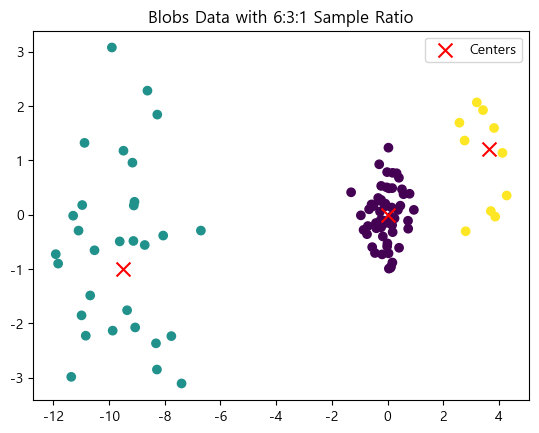

In [85]:
# 생성예시
# 6:3:1 비율로 데이터 샘플 설정
n_samples = [60, 30, 10]  # 6:3:1 비율로 1000개의 데이터 생성

# 첫 번째 클러스터는 (0, 0)에 위치, 나머지 두 개는 랜덤 위치
random_centers = np.random.uniform(low=-10, high=10, size=(2, 2))
centers = np.vstack([[0, 0], random_centers])

# 데이터 생성 (클러스터별 샘플 수 할당)
blobs_data, blobs_labels = make_blobs(n_samples=n_samples, centers=centers, cluster_std=[0.5, 1.5, 1.0], random_state=42)

# 시각화
plt.scatter(blobs_data[:, 0], blobs_data[:, 1], c=blobs_labels, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100, label='Centers')
plt.title('Blobs Data with 6:3:1 Sample Ratio')
plt.legend()
plt.show()


##### 부당 데이터 생성 함수

In [86]:
def generate_blobs_data(total_samples, max_cluster=3, p=[0.7, 0.3]):
    # 클러스터 갯수 2~max_cluster개 (주어진 확률 분포에 따라 선택)
    num_clusters = np.random.choice([2, max_cluster], p=p)
    
    # 비율 무작위 생성 후 정렬 (높은 비율이 앞에 오도록)
    ratio = np.random.dirichlet(np.ones(num_clusters), size=1)[0]
    ratio = sorted(ratio, reverse=True)

    # 샘플 수는 총합이 total_samples가 되도록 비율에 맞게 분배
    n_samples = [int(total_samples * r) for r in ratio]
    diff = total_samples - sum(n_samples)
    n_samples[0] += diff  # 남은 차이를 첫번째 클러스터에 추가

    # 첫 번째 클러스터는 (0, 0)에 위치, 나머지 클러스터는 랜덤 위치
    # std 1을 50m로 하기 때문에 20은 10km에 해당. 최대 14.4km 차이 날 수 있음
    random_centers = np.random.uniform(low=-20, high=20, size=(num_clusters - 1, 2))
    centers = np.vstack([[0, 0], random_centers])

    # 표준편차는 0.5 ~ 2.0 사이에서 랜덤으로 설정
    cluster_std = np.random.uniform(0.5, 2.0, size=num_clusters)

    # 데이터 생성
    blobs_data = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std)

    # 결과 리턴 (데이터, 레이블, 클러스터 정보)
    # return blobs_data, blobs_labels, centers, n_samples, ratio
    return blobs_data


##### 부당 데이터 함수 테스트

In [87]:
# 함수 호출 예시
blobs_data, blobs_labels = generate_blobs_data(100, max_cluster=3, p=[0.7, 0.3])
blobs_data,blobs_data.shape, blobs_labels, blobs_labels.shape

(array([[20.02755787, -4.06539262],
        [ 0.5520015 ,  2.83625471],
        [20.54459923, -4.83319937],
        ...,
        [-0.74773043, -0.93358896],
        [-0.92741694, -0.50825832],
        [-0.15985453, -0.27861322]]),
 (100, 2),
 array([1, 0, 1, ..., 0, 0, 0]),
 (100,))

In [88]:
noise, noise.shape, blobs_data, blobs_data.shape

(array([[[-0.41488015,  0.12927717],
         [-1.78046201, -1.2602068 ],
         [-1.14522807,  1.59624824],
         ...,
         [ 0.06553096, -1.13681076],
         [ 0.44269032, -0.98996931],
         [-0.79216484,  1.06009953]],
 
        [[-0.36602303, -0.57906618],
         [-0.05129755, -0.3531997 ],
         [ 0.99900599, -0.74534478],
         ...,
         [-0.25331432,  0.77382281],
         [ 0.25495027, -0.05948071],
         [ 0.67842232,  1.15935632]],
 
        [[ 0.98994628, -2.85641745],
         [ 0.22111095,  0.26593425],
         [-0.00681752, -0.19011527],
         ...,
         [ 0.87727605, -0.30316137],
         [ 0.33708574,  2.67189158],
         [ 1.87710082,  2.35469883]],
 
        ...,
 
        [[-1.88046263, -1.1205346 ],
         [-1.65911122,  0.55232915],
         [ 1.08521526,  1.29883725],
         ...,
         [-0.13162873, -0.15558004],
         [-0.15146864,  1.18524746],
         [ 1.15917927,  0.09550857]],
 
        [[-1.43681709, -0.535

##### 기본 noise를 부당 noise로 대체하기

In [89]:
## target에 대해 noise 대체하기
for idx in y_target:
    blobs_data, blobs_labels = generate_blobs_data(100, max_cluster=3, p=[0.7, 0.3])
    noise[idx] = blobs_data
print(noise_before_mean - np.mean(noise), noise_before_mean, np.mean(noise))

0.00048656043728028656 -6.446641325141857e-05 -0.0005510268505317051


In [90]:
y_target.shape

(3000,)

### 수급자 정보 병합 후 csv 저장

#### prs 데이터 수집

In [91]:
region_sorted = np.sort(region)

In [92]:
prs_meta = {
    'ID':'longtermcare_id',
    'NM':'name',
    'GRADE':'grade',
    'BIRTHDAY':'birth_day',
    'ADDRESS_SIDO_NM':'region_sorted',
    'ADDRESS_INDEX':'sampled_indices',  ### 요게 문제인데... 샘플 index 가져와야함
    'GPS_BASE':'base_gps',
    'GPS_NOISE':'noise'
}

In [93]:
# 각 배열의 shape를 확인하는 코드
for key, value in prs_meta.items():
    try:
        # 배열 평가 및 shape 출력
        array = eval(value.split('[')[0])  # 인덱스 부분 제외하고 평가
        print(f"{key}: {array.shape}")
    except Exception as e:
        print(f"Error for {key}: {e}")

ID: (100007,)
NM: (100007,)
GRADE: (100007,)
BIRTHDAY: (100007, 1)
ADDRESS_SIDO_NM: (100007,)
ADDRESS_INDEX: (100007,)
GPS_BASE: (100007, 2)
GPS_NOISE: (100007, 100, 2)


##### dataframe 생성

In [94]:
df_data = {}

for key, value in prs_meta.items():
    try:
        array = eval(value.split('[')[0])  # 배열 변수 평가
        if array.ndim == 1:  # 1D 배열일 경우 그대로 추가
            df_data[key] = array
        elif array.ndim == 2:  # 2D 배열일 경우 열을 나눔
            for i in range(array.shape[1]):
                df_data[f"{key}_{i}"] = array[:, i]
    except Exception as e:
        print(f"Error processing {key}: {e}")

# DataFrame 생성
df = pd.DataFrame(df_data)
df

,ID,NM,GRADE,BIRTHDAY_0,ADDRESS_SIDO_NM,ADDRESS_INDEX,GPS_BASE_0,GPS_BASE_1
0,L160034205,김너주,3,1934-04-07,강원특별자치도,135415,128.023627,37.721240
1,L110018660,이터빌,3,1944-03-23,강원특별자치도,200593,128.020061,38.176570
2,L090088482,박돌보,3,1940-01-10,강원특별자치도,536,127.674917,37.838683
3,L210048725,류조산,5,1932-06-28,강원특별자치도,187512,127.404210,38.277389
4,L210051942,서춤논,4,1946-05-03,강원특별자치도,179318,128.702571,37.470652
...,...,...,...,...,...,...,...,...
100002,L180046596,이훈시,5,1939-05-11,충청북도,3574815,127.834434,36.947349
100003,L140085933,이톨핑,3,1932-05-11,충청북도,3624114,127.705558,36.513158
100004,L160032853,황둠차,3,1945-09-29,충청북도,3566713,127.847609,36.926632
100005,L200034268,노서티,3,1944-08-04,충청북도,3573949,127.859228,36.918517


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100007 entries, 0 to 100006
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               100007 non-null  object 
 1   NM               100007 non-null  object 
 2   GRADE            100007 non-null  int32  
 3   BIRTHDAY_0       100007 non-null  object 
 4   ADDRESS_SIDO_NM  100007 non-null  object 
 5   ADDRESS_INDEX    100007 non-null  int32  
 6   GPS_BASE_0       100003 non-null  float64
 7   GPS_BASE_1       100003 non-null  float64
dtypes: float64(2), int32(2), object(4)
memory usage: 5.3+ MB


In [96]:
base_gps.shape

(100007, 2)

In [97]:
df[(df['GPS_BASE_0'].isna()) | (df['GPS_BASE_0'].isna())]

,ID,NM,GRADE,BIRTHDAY_0,ADDRESS_SIDO_NM,ADDRESS_INDEX,GPS_BASE_0,GPS_BASE_1
9162,L120026239,백운멍,3,1939-01-09,경기도,493384,NaN,NaN
10025,L110045648,김니하,1,1946-04-24,경기도,500351,NaN,NaN
50590,L090061666,이봄디,5,1943-12-10,부산광역시,1818108,NaN,NaN
93613,L130048396,장터홀,3,1946-12-26,충청남도,3223820,NaN,NaN


In [98]:
df = df.dropna()
df = df.reset_index().drop('index', axis=1)
df = df[df.index < 100000]
df

,ID,NM,GRADE,BIRTHDAY_0,ADDRESS_SIDO_NM,ADDRESS_INDEX,GPS_BASE_0,GPS_BASE_1
0,L160034205,김너주,3,1934-04-07,강원특별자치도,135415,128.023627,37.721240
1,L110018660,이터빌,3,1944-03-23,강원특별자치도,200593,128.020061,38.176570
2,L090088482,박돌보,3,1940-01-10,강원특별자치도,536,127.674917,37.838683
3,L210048725,류조산,5,1932-06-28,강원특별자치도,187512,127.404210,38.277389
4,L210051942,서춤논,4,1946-05-03,강원특별자치도,179318,128.702571,37.470652
...,...,...,...,...,...,...,...,...
99995,L130031750,김놀펄,4,1951-05-24,충청북도,3554944,127.537532,36.659409
99996,L180014004,최딩비,5,1945-05-31,충청북도,3645986,127.590550,36.973971
99997,L080074648,김처두,1,1941-07-08,충청북도,3602226,128.205037,37.097820
99998,L180046596,이훈시,5,1939-05-11,충청북도,3574815,127.834434,36.947349


In [99]:
np.min(noise), np.max(noise), noise.shape

(-25.960832962328972, 25.502354387844445, (100007, 100, 2))

In [100]:
noise = noise[:100000, :, :]

In [101]:
noise

array([[[-4.14880149e-01,  1.29277168e-01],
        [-1.78046201e+00, -1.26020680e+00],
        [-1.14522807e+00,  1.59624824e+00],
        ...,
        [ 6.55309577e-02, -1.13681076e+00],
        [ 4.42690318e-01, -9.89969314e-01],
        [-7.92164836e-01,  1.06009953e+00]],

       [[-3.66023026e-01, -5.79066179e-01],
        [-5.12975506e-02, -3.53199700e-01],
        [ 9.99005987e-01, -7.45344775e-01],
        ...,
        [-2.53314315e-01,  7.73822808e-01],
        [ 2.54950270e-01, -5.94807082e-02],
        [ 6.78422320e-01,  1.15935632e+00]],

       [[ 9.89946284e-01, -2.85641745e+00],
        [ 2.21110946e-01,  2.65934251e-01],
        [-6.81751542e-03, -1.90115266e-01],
        ...,
        [ 8.77276046e-01, -3.03161371e-01],
        [ 3.37085740e-01,  2.67189158e+00],
        [ 1.87710082e+00,  2.35469883e+00]],

       ...,

       [[ 6.71060273e-02, -4.55045979e-01],
        [-2.04121116e+00, -2.34873536e-01],
        [-5.55465015e-01,  9.98213919e-01],
        ...,
     

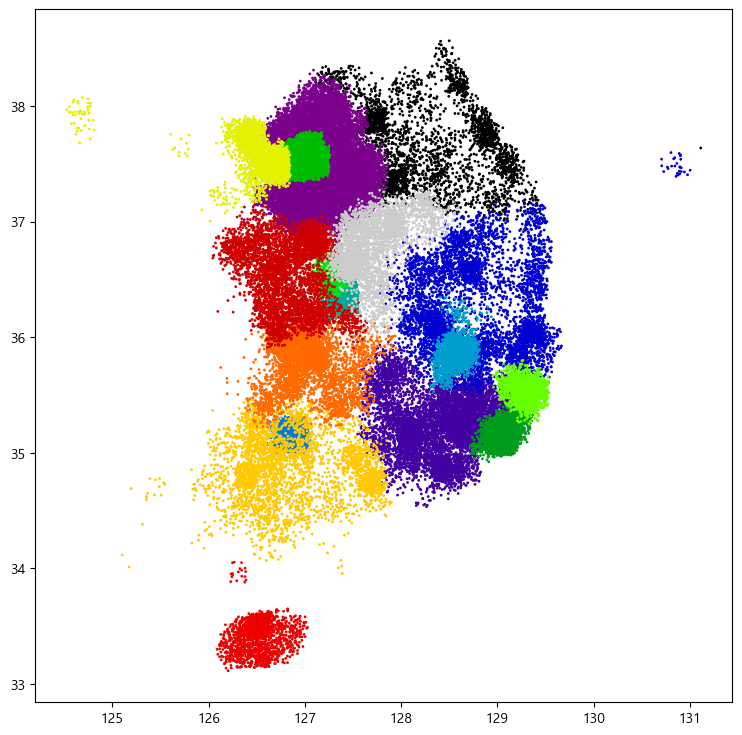

In [102]:
# LabelEncoder로 지역 이름을 숫자로 변환
le = LabelEncoder()
region_encoded = le.fit_transform(df['ADDRESS_SIDO_NM'])
	#ADDRESS_INDEX	GPS_BASE_0	GPS_BASE_1
#산점도 그리기	ADDRESS_SIDO_NM	GPS_BASE_0	GPS_BASE_1
#sns.scatterplot(df, x='GPS_BASE_0', y = 'GPS_BASE_1', hue='ADDRESS_SIDO_NM')
plt.figure(figsize=(9,9))
plt.scatter(df['GPS_BASE_0'], df['GPS_BASE_1'], c=region_encoded, cmap='nipy_spectral', s=1)

#'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

#### 2500개 기관으로 분류

In [103]:
# K-means 클러스터링 적용 (클러스터 수는 5개로 설정)
kmeans = KMeans(n_clusters=2500)
kmeans.fit(df[['GPS_BASE_0',	'GPS_BASE_1']])

KMeans(n_clusters=2500)

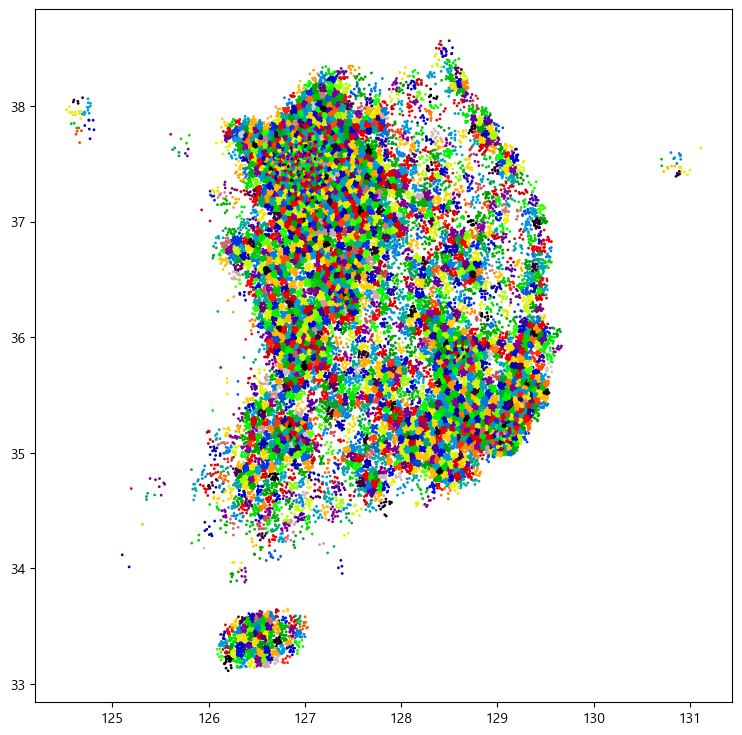

In [104]:

plt.figure(figsize=(9,9))
plt.scatter(df['GPS_BASE_0'], df['GPS_BASE_1'], c=kmeans.labels_, cmap='nipy_spectral', s=1)

In [105]:
df['cluster'] = kmeans.labels_

# 클러스터별 카운트
cluster_counts = df['cluster'].value_counts().sort_index()

In [106]:
# 클러스터별로 첫 번째 데이터를 선택
df_first_in_cluster = df.groupby('cluster').first().reset_index()

# a 부분: 2 또는 3 중 랜덤 선택
df_first_in_cluster['a'] = np.random.choice([2, 3], size=len(df_first_in_cluster))

# bbbbb 부분: ADDRESS_SIDO_NM별 5자리 랜덤 숫자 생성
sido_unique = df_first_in_cluster['ADDRESS_SIDO_NM'].unique()
sido_random_map = {sido: np.random.randint(10000, 99999) for sido in sido_unique}

# ADDRESS_SIDO_NM별로 동일한 5자리 랜덤 숫자 부여
df_first_in_cluster['bbbbb'] = df_first_in_cluster['ADDRESS_SIDO_NM'].map(sido_random_map)

# ccccc 부분: ADDRESS_SIDO_NM별 일련번호 (1부터 시작)
df_first_in_cluster['ccccc'] = df_first_in_cluster.groupby('ADDRESS_SIDO_NM').cumcount() + 1

# a-bbbbb-ccccc 형식의 기관 ID 생성
df_first_in_cluster['LTC_ID'] = (
    df_first_in_cluster['a'].astype(str) + '-' +
    df_first_in_cluster['bbbbb'].astype(str) + '-' +
    df_first_in_cluster['ccccc'].astype(str).str.zfill(5)
)

In [107]:
df_first_in_cluster

,cluster,ID,NM,GRADE,BIRTHDAY_0,ADDRESS_SIDO_NM,ADDRESS_INDEX,GPS_BASE_0,GPS_BASE_1,a,bbbbb,ccccc,LTC_ID
0,0,L110053345,허힘마,3,1947-05-26,경기도,275027,127.235848,37.402932,2,11674,1,2-11674-00001
1,1,L110000576,오비말,4,1931-12-17,경상남도,781167,128.650202,35.299455,3,63103,1,3-63103-00001
2,2,L240090608,박피사,5,1955-05-01,광주광역시,1459496,126.834604,35.243069,3,47518,1,3-47518-00001
3,3,L170078248,김참니,3,1927-07-09,대전광역시,1700409,127.399958,36.384500,2,78922,1,2-78922-00001
4,4,L080084000,강섬벙,4,1934-03-17,강원특별자치도,159812,128.725599,37.009699,3,86247,1,3-86247-00001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2495,L080099430,김이투,4,1947-01-02,광주광역시,1495171,126.848107,35.068322,3,47518,62,3-47518-00062
2496,2496,L180001477,조오다,4,1937-11-14,경기도,650345,127.116457,37.984390,3,11674,617,3-11674-00617
2497,2497,L170030402,박토머,1,1936-12-11,경기도,621681,127.313912,37.396144,2,11674,618,2-11674-00618
2498,2498,L080085098,이털덤,1,1945-04-15,경상북도,1299050,128.912935,35.812942,2,16669,322,2-16669-00322


In [108]:
df_first_in_cluster['LTC_ID'].nunique()

2500

In [109]:
df = df.merge(df_first_in_cluster[['cluster', 'LTC_ID']], on='cluster', how='left')
df

,ID,NM,GRADE,BIRTHDAY_0,ADDRESS_SIDO_NM,ADDRESS_INDEX,GPS_BASE_0,GPS_BASE_1,cluster,LTC_ID
0,L160034205,김너주,3,1934-04-07,강원특별자치도,135415,128.023627,37.721240,258,3-86247-00028
1,L110018660,이터빌,3,1944-03-23,강원특별자치도,200593,128.020061,38.176570,1150,2-86247-00111
2,L090088482,박돌보,3,1940-01-10,강원특별자치도,536,127.674917,37.838683,2120,3-86247-00207
3,L210048725,류조산,5,1932-06-28,강원특별자치도,187512,127.404210,38.277389,292,3-86247-00034
4,L210051942,서춤논,4,1946-05-03,강원특별자치도,179318,128.702571,37.470652,1830,3-86247-00186
...,...,...,...,...,...,...,...,...,...,...
99995,L130031750,김놀펄,4,1951-05-24,충청북도,3554944,127.537532,36.659409,1675,2-15591-00046
99996,L180014004,최딩비,5,1945-05-31,충청북도,3645986,127.590550,36.973971,2264,2-11674-00561
99997,L080074648,김처두,1,1941-07-08,충청북도,3602226,128.205037,37.097820,1995,3-15591-00056
99998,L180046596,이훈시,5,1939-05-11,충청북도,3574815,127.834434,36.947349,2443,2-15591-00070


In [ ]:
df = df[['ID','LTC_ID','NM','GRADE','BIRTHDAY_0','ADDRESS_SIDO_NM','ADDRESS_INDEX','GPS_BASE_0','GPS_BASE_1']]
df

In [116]:
df = df.rename(columns={'GPS_BASE_0': 'GPS_BASE_X', 'GPS_BASE_1': 'GPS_BASE_Y'})

In [118]:
df.to_csv('prs_dummy_data.csv')

In [115]:
# 파일로 저장 (pickle 형식) ## noise는 일단 별도로 저장...
with open('gps_noise.pkl', 'wb') as f:
    pickle.dump(noise, f)

In [114]:
df

,ID,LTC_ID,NM,GRADE,BIRTHDAY_0,ADDRESS_SIDO_NM,ADDRESS_INDEX,GPS_BASE_0,GPS_BASE_1
0,L160034205,3-86247-00028,김너주,3,1934-04-07,강원특별자치도,135415,128.023627,37.721240
1,L110018660,2-86247-00111,이터빌,3,1944-03-23,강원특별자치도,200593,128.020061,38.176570
2,L090088482,3-86247-00207,박돌보,3,1940-01-10,강원특별자치도,536,127.674917,37.838683
3,L210048725,3-86247-00034,류조산,5,1932-06-28,강원특별자치도,187512,127.404210,38.277389
4,L210051942,3-86247-00186,서춤논,4,1946-05-03,강원특별자치도,179318,128.702571,37.470652
...,...,...,...,...,...,...,...,...,...
99995,L130031750,2-15591-00046,김놀펄,4,1951-05-24,충청북도,3554944,127.537532,36.659409
99996,L180014004,2-11674-00561,최딩비,5,1945-05-31,충청북도,3645986,127.590550,36.973971
99997,L080074648,3-15591-00056,김처두,1,1941-07-08,충청북도,3602226,128.205037,37.097820
99998,L180046596,2-15591-00070,이훈시,5,1939-05-11,충청북도,3574815,127.834434,36.947349
